# Fast-track land suitability for avocado in Morocco

Authors: Gianluca Franceschini (FAO, NSL), Shrijwal Adhikari (FAO, NSL)

Contact: gianluca.franceschini@fao.org / shrijwal.adhikari@fao.org

---

The present study assess the land suitable for avocado in Morocco, extending the analysis conducted by Rachid Moussadek and Hamza Iaaich in 2020 comprising the region of Rabat, Salé, Kénitra and the province of Larache. 

We used a similar approach extending the area of analysis at the whole country with global available georeferenced imagery on climate, physiography and soil characteristics. These factors are matched against specific thresholds identifying optimal suitable, intermediate and not suitable conditions. Then, the individual layers were overlaid to get a final score for the whole area of interest. The purpose of the analysis was to prototype a fast-track land suitability assessment and more specifically to test whether alternative suitable areas for avocado are available in the country other than those identified in 2020. 

In [1]:
"""Import libraries"""
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from osgeo import gdal

In [2]:
"""Set parameters"""
base_path = r"/home/data" #Root to be updated if different
os.chdir(base_path)
ref_raster = './Climate/Chirps.tif'


|**Data** |**Source** |**Provider** |**Resolution**|
|:-- |:-- |:-- |:-- |
|Minimum Temperature |ERA5 |ECMWF / Copernicus Climate Change Service |9km|
|Maximum Temperature |ERA5 |ECMWF / Copernicus Climate Change Service |9km|
|Precipitation |CHIRPS |UCSB/CHG |1km|
|Slope|SRTMv4 |NASA/CGIAR |30m|
|Aspect |SRTMv4 |NASA/CGIAR |30m|
|Soil |HSWD |FAO/IIASA |1km|

---

**CHIRPS citation**:
Funk, Chris, Pete Peterson, Martin Landsfeld, Diego Pedreros, James Verdin, Shraddhanand Shukla, Gregory Husak, James Rowland, Laura Harrison, Andrew Hoell & Joel Michaelsen. "The climate hazards infrared precipitation with stations—a new environmental record for monitoring extremes". Scientific Data 2, 150066. doi:10.1038/sdata.2015.66 2015.

**ERA5 citation**:
Copernicus Climate Change Service (C3S) (2017): ERA5: Fifth generation of ECMWF atmospheric reanalyses of the global climate. Copernicus Climate Change Service Climate Data Store (CDS), https://cds.climate.copernicus.eu/cdsapp#!/home

**SRTM citation**:
The Shuttle Radar Topography Mission (SRTM) digital elevation dataset was originally produced to provide consistent, high-quality elevation data at near global scope. The version 4 of the SRTM digital elevation data has been processed to fill data voids, and to facilitate its ease of use.

**HWSD citation**:
Fischer, G., F. Nachtergaele, S. Prieler, H.T. van Velthuizen, L. Verelst, D. Wiberg, 2008. Global Agro-ecological Zones Assessment for Agriculture (GAEZ 2008). IIASA, Laxenburg, Austria and FAO, Rome, Italy.




In [ ]:
"""Read data"""

ph = gdal.Open('./Soil/MAR_T_PH_H2O_CLIP.tif').ReadAsArray()
ph = ph[:-1,:-1] #Remove one line to have the same shape
precip = gdal.Open('./Climate/Chirps.tif').ReadAsArray()
tmax = gdal.Open('./Climate/Tmax.tif').ReadAsArray()
tmin = gdal.Open('./Climate/Tmin.tif').ReadAsArray()
dem  = gdal.Open('./Terrain/Elevation.tif').ReadAsArray()
slope  = gdal.Open('./Terrain/Slope.tif').ReadAsArray()
aspect  = gdal.Open('./Terrain/Aspect.tif').ReadAsArray()

In [4]:
"""Function to export the results"""
def saveRaster(ref_raster_path, out_path, numpy_raster):

    # Read random image to get projection data
    img = gdal.Open(ref_raster_path)
    # allocating space in hard drive
    driver = gdal.GetDriverByName("GTiff")
    outdata = driver.Create(out_path, img.RasterXSize, img.RasterYSize, 1, gdal.GDT_Float32)
    # set image paramenters (infrormation related to cordinates)
    outdata.SetGeoTransform(img.GetGeoTransform())
    outdata.SetProjection(img.GetProjection())
    # write numpy matrix as new band and set no data value for the band
    outdata.GetRasterBand(1).WriteArray(numpy_raster)
    outdata.GetRasterBand(1).SetNoDataValue(0)
    # flush data from memory to hard drive
    outdata.FlushCache()
    outdata=None

## Crop parameters

A land suitabilty analysis matches specific crop tolerance for soil, terrain and climate with local prevailing conditions. In order to assess the suitable thresholds for avocado, the **ECOCROP** database was used to define these values. The thresholds are typically defined for optimum conditions where the crop growth is not constraint and can express its full potential, to moderate suitability where crop growth is somehow limited, to unsuitable conditions whereas specific values of a certain factor prevent the crop growth (irrespective from the values of the other parameters, that could be potentially suitable).

The following thresholds have been used for avocado:

|**Parameter** |**Optimum min** |**Optimum max** |**Absolute min**|**Absolute max**|
|:-- |:-- |:-- |:-- |:-- |
|Minimum Temperature |14°C |na|10°C |na|
|Maximum Temperature |na |40°C |na|45°C |
|Precipitation |500mm |2000mm |2500mm|300mm |
|Slope|less than 2° |na |na|15°|
|Aspect |All except South and South-East |na |na|na |
|Soil ph |5 |5.8 |4.5|7 |

## Climate analysis

Climate analysis looked at identifying best available conditions for the growth of avocado. Even though the growth of avocado is supplemented with irrigation, conditions where rainfall is abundant were considered more suitable. For temperature, minumum and maximum conditions were analyzed separetely.

Data was preprocessed in Google Earth Engine as follows:
- For precipitation, an accumulated annual precipitation was calculated for the period 1990:2020, and then a long-term average was calculated;
- For minimum temperature, the 2m daily minimum temperature was averaged for each year for the period 1990:2020 and then a long-term average was calculated;
- For maximum temperature, the maximum of the 2m daily maximum temperature was calculated for each year for the period 1990:2020 and then a long-term average was calculated.


In [5]:
#Define the thresholds for precipitation 
rainfall_opt_max = 2000
rainfall_opt_min = 500
rainfall_abs_max = 2500
rainfall_abs_min = 300

precip_suitability = precip.copy()
precip_suitability[(precip_suitability >= rainfall_abs_max) | (precip_suitability < rainfall_abs_min)] = 0 #Not suitable
precip_suitability[((precip_suitability >= rainfall_abs_min) & (precip_suitability < rainfall_opt_min)) | ((precip_suitability >= rainfall_opt_max) & (precip_suitability < rainfall_abs_max))] = 1 #Moderate Suitable
precip_suitability[(precip_suitability >= rainfall_opt_min) & (precip_suitability <= rainfall_opt_max)] = 2 #Suitable

#Export results
saveRaster(ref_raster, "./Kuitability/precip_suitability.tif", precip_suitability)

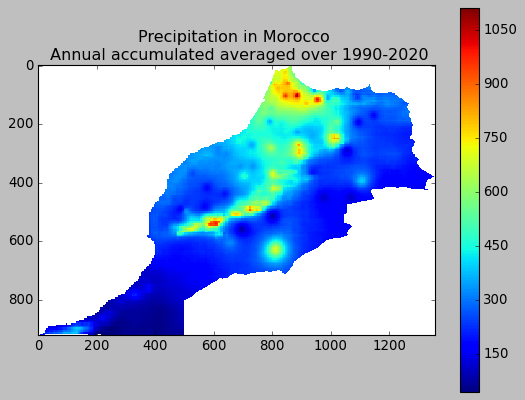

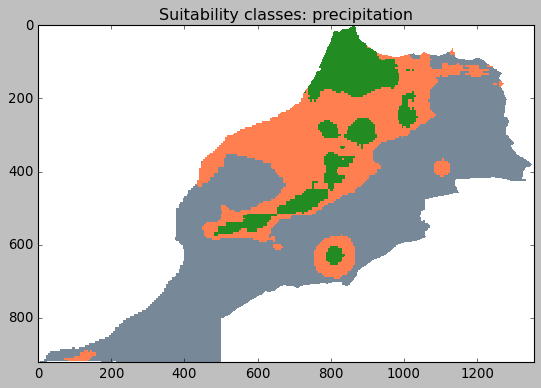

In [6]:
"""Display results"""
cmap_suitability = colors.ListedColormap(['lightslategrey', 'coral', 'forestgreen']) #Define a palette
plt.style.use("classic")
plt.imshow(precip)
plt.title("Precipitation in Morocco \n Annual accumulated averaged over 1990-2020")
plt.colorbar()
plt.show()

plt.imshow(precip_suitability, cmap=cmap_suitability)
plt.title("Suitability classes: precipitation")
plt.show()

In [7]:
#Define the thresholds for temperature max
temperature_opt_max = 40;
temperature_abs_max = 45;

tmax_suitability = tmax.copy()
tmax_suitability[tmax_suitability < temperature_opt_max] = 2 #Suitable
tmax_suitability[(tmax_suitability >= temperature_opt_max) & (tmax_suitability < temperature_abs_max)] = 1 #Moderate Suitable
tmax_suitability[tmax_suitability >= temperature_abs_max] = 0 #Not suitable

#Export results
saveRaster(ref_raster, "./Kuitability/tmax_suitability.tif", tmax_suitability)

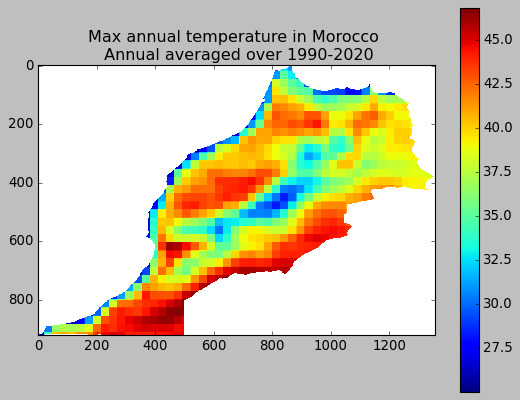

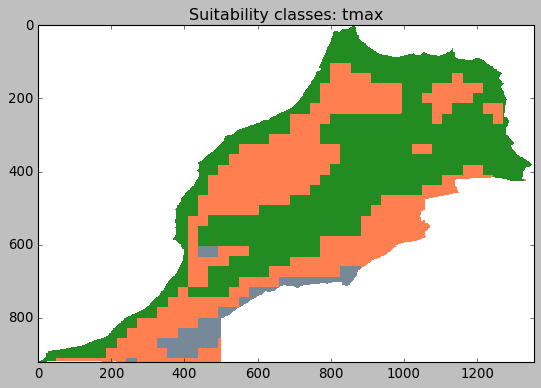

In [8]:
"""Display results"""
plt.imshow(tmax)
plt.title("Max annual temperature in Morocco \n Annual averaged over 1990-2020")
plt.colorbar()
plt.show()

plt.imshow(tmax_suitability, cmap=cmap_suitability)
plt.title("Suitability classes: tmax")
plt.show()

In [9]:
#Define the thresholds for temperature min
temperature_opt_min = 14;
temperature_abs_min = 10;

tmin_suitability = tmin.copy()
tmin_suitability[tmin_suitability < temperature_abs_min] = 0 #Not Suitable
tmin_suitability[(tmin_suitability >= temperature_abs_min) & (tmin_suitability < temperature_opt_min)] = 1 #Moderate Suitable
tmin_suitability[tmin_suitability >= temperature_opt_min] = 2 #Suitable

#Export results
saveRaster(ref_raster, "./Kuitability/tmin_suitability.tif", tmin_suitability)

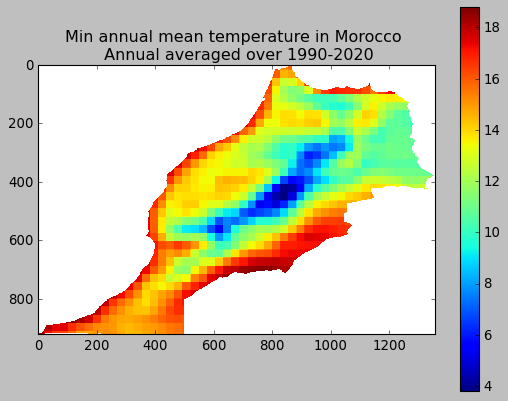

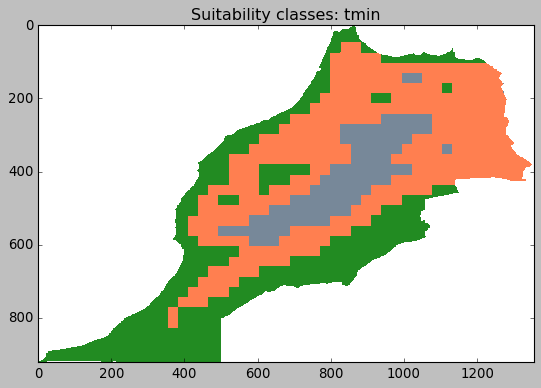

In [10]:
"""Display results"""
plt.imshow(tmin)
plt.title("Min annual mean temperature in Morocco \n Annual averaged over 1990-2020")
plt.colorbar()
plt.show()

plt.imshow(tmin_suitability, cmap=cmap_suitability)
plt.title("Suitability classes: tmin")
plt.show()

## Physiographic analysis

The physiographic analysis looked at suitable conditions in terms of slope and aspect. South and south-east expositions are considered not suitable for the growth of avocado.

Data were generated from a Digital Elevation Model (DEM) in Google Earth Engine and then clipped and downloaded.

In [11]:
#Define the thresholds for slope 
slope_abs_max = 15
slope_opt_max = 2

slope_suitability = slope.copy()
slope_suitability[slope_suitability <= slope_opt_max] = 2 #Suitable
slope_suitability[(slope_suitability > slope_opt_max) & (slope_suitability < slope_abs_max)] = 1 #Moderate Suitable
slope_suitability[slope_suitability >= slope_abs_max] = 0 #Not Suitable

#Export results
saveRaster(ref_raster, "./Kuitability/slope_suitability.tif", slope_suitability)

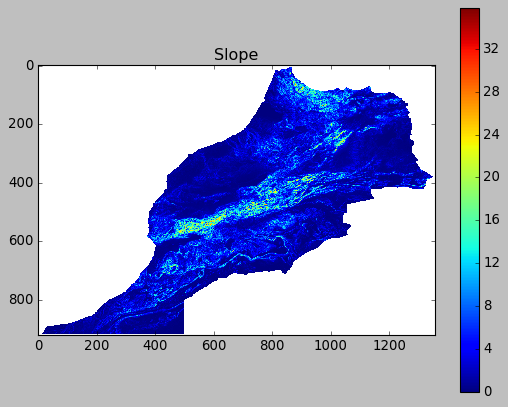

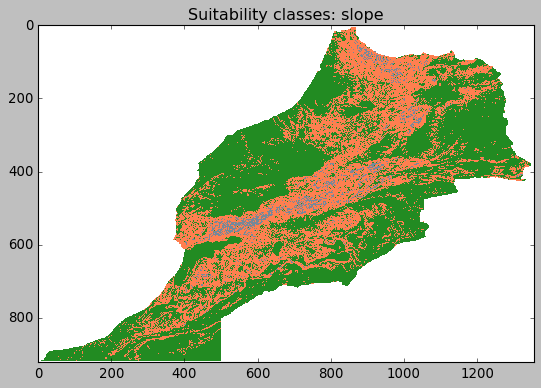

In [12]:
"""Display results"""
plt.imshow(slope)
plt.title("Slope")
plt.colorbar()
plt.show()

plt.imshow(slope_suitability, cmap=cmap_suitability)
plt.title("Suitability classes: slope")
plt.show()

In [13]:
#Define the thresholds for aspect 
#Areas oriented to south and south-east are not suitable
#Which corresponds to the following degrees:
#Southeast (112.5° to 157.5°)
#South (157.5° to 202.5°)

aspect_min = 112.5
aspect_max = 202.5

aspect_suitability = aspect.copy()
aspect_suitability[(aspect_suitability > aspect_min) & (aspect_suitability < aspect_max)] = -99 #Not suitable
aspect_suitability[aspect_suitability >= 0] = 2 #Suitable
aspect_suitability[aspect_suitability == -99] = 0 #Not Suitable

#Export results
saveRaster(ref_raster, "./Kuitability/aspect_suitability.tif", aspect_suitability)

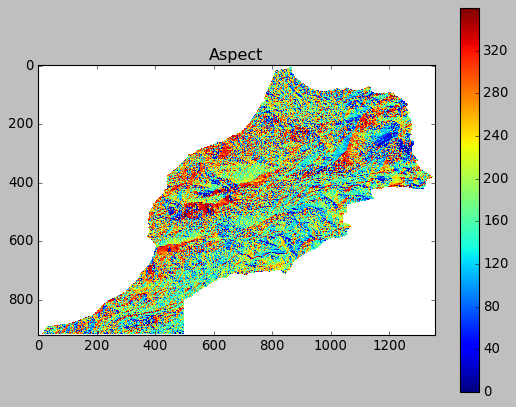

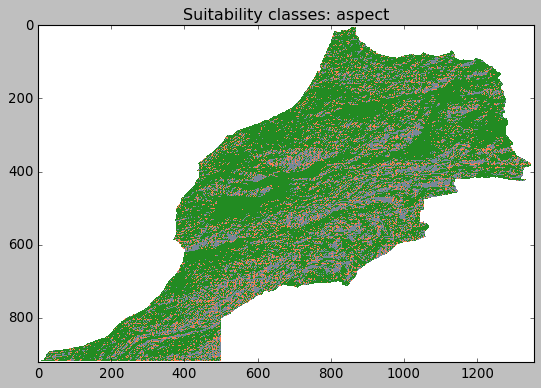

In [14]:
"""Display results"""
plt.imshow(aspect)
plt.title("Aspect")
plt.colorbar()
plt.show()

plt.imshow(aspect_suitability, cmap=cmap_suitability)
plt.title("Suitability classes: aspect")
plt.show()

## Soil Parameter Analysis
The soil parameters are derived from the Harmonized World Soil Database in raster format. The database consists of various soil parameters as factors necessary for the Avocado production, which includes soil pH, salinity, soil texture, depth of the top soil and drainage of the soil.

The original raster file contains values (or IDs) which has to be matched with the code for each of the above soil parameters. So, the original raster file was joined with the soil parameter table to derive raster of all above soil parameters.

Finally, the soil parameters were tallied against optimum values for Avocado production. It was found that only soil pH was the limiting factor for Avocado and hence, this is only included in the analysis. All other soil parameters (i.e salinity, soil texture, drainage and depth of top soil) were adequately suitable for the growth.


In [15]:
#Define the thresholds for pH 
ph_opt_max = 5.8
ph_opt_min = 5
ph_abs_max = 7
ph_abs_min = 4.5

ph_suitability = ph.copy()
ph_suitability[ph_suitability == -999] = 0 #Not suitable
ph_suitability[ph_suitability < ph_abs_min] = 0 #Not suitable
ph_suitability[(ph_suitability >= ph_abs_min) & (ph_suitability < ph_opt_min)] = 1 #Moderate Suitable
ph_suitability[(ph_suitability >= ph_opt_min) & (ph_suitability < ph_opt_max)] = 2 #Suitable
ph_suitability[(ph_suitability >= ph_opt_max) & (ph_suitability < ph_abs_max)] = 1 #Moderate Suitable
ph_suitability[ph_suitability >= ph_abs_max] = 0 #Not suitable

#Export results
saveRaster(ref_raster, "./Kuitability/ph_suitability.tif", ph_suitability)

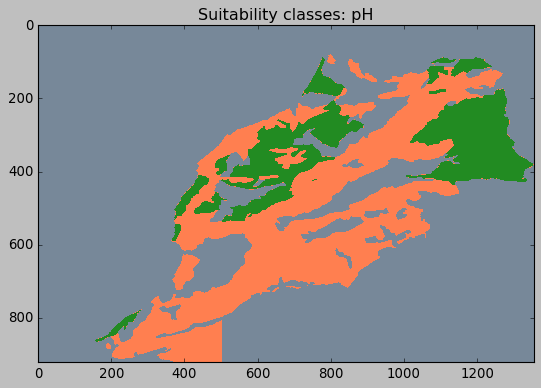

In [16]:
"""Display results"""
plt.imshow(ph_suitability, cmap=cmap_suitability)
plt.title("Suitability classes: pH")
plt.show()

## Combining layers
Finally, all the climatic, terrain and soil pH layers were overlaid and a suitability later is generated indicating higher value as more suitable layer.
Unsuitable layer is generated from the condition where atleast one layer/pixel is unsuitable for Avocado.

In [17]:
"""Combine layers"""
#Any pixel where at least one layer is unsuitable is set to unsuitable
test = aspect_suitability.copy() 
test[precip_suitability == 0] = 0
test[tmax_suitability == 0] = 0
test[tmin_suitability == 0] = 0
test[aspect_suitability == 0] = 0
test[slope_suitability == 0] = 0
test[ph_suitability == 0] = 0
combined = aspect_suitability + slope_suitability + precip_suitability + tmax_suitability + tmin_suitability + ph_suitability
result = np.where(test > 0, combined, 0 )

#Export results
saveRaster(ref_raster, "./Kuitability/result.tif", result)

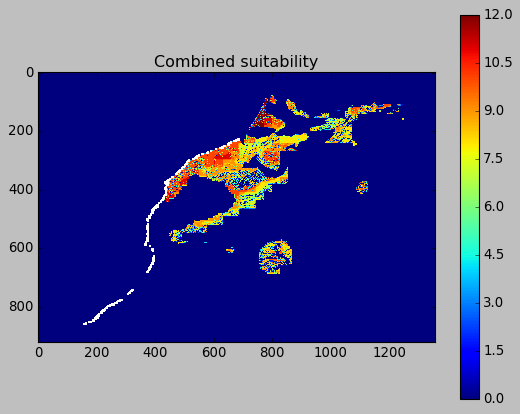

In [18]:
plt.imshow(result)
plt.title("Combined suitability")
plt.colorbar()
plt.show()
